In [1]:
!pip install yfinance pandas numpy matplotlib scikit-learn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# function to compute RSI (relative strength index)
def compute_rsi(data, window):
    delta = data.diff()

    gain = pd.Series(np.where(delta > 0, delta, 0))
    loss = pd.Series(np.where(delta < 0, -delta, 0))

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Function to compute MACD (moving average convergence/divergence) and Signal Line
def compute_macd(data):
    short_ema = data.ewm(span=12, adjust=False).mean()
    long_ema = data.ewm(span=26, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=9, adjust=False).mean()
    return MACD, signal_line

In [4]:
# Downloading stock market data
index_symbol = '^GSPC'  # S&P 500 index symbol
start_date = '2011-01-01'
end_date = '2023-01-01'
data = yf.download(index_symbol, start=start_date, end=end_date)

# calculating the log of the returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# simple moving average with window 20
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# exponential moving averge with span 20
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()


rsi_series = compute_rsi(data['Close'], 14)
rsi_series.index = data['Close'].index  # Aligning indices
data['RSI'] = rsi_series


data['MACD'], data['Signal_Line'] = compute_macd(data['Close'])


[*********************100%%**********************]  1 of 1 completed


In [5]:
# Drop NaN values
data.dropna(inplace=True)

In [6]:
data

,Open,High,Low,Close,Adj Close,Volume,Log_Returns,SMA_20,EMA_20,RSI,MACD,Signal_Line
Date,,,,,,,,,,,,
2011-01-31,1276.500000,1287.170044,1276.500000,1286.119995,1286.119995,4167160000,0.007633,1282.618500,1283.797263,58.465190,4.046104,4.099679
2011-02-01,1289.140015,1308.859985,1289.140015,1307.589966,1307.589966,5164500000,0.016556,1284.404498,1286.063235,64.594891,5.444911,4.368726
2011-02-02,1305.910034,1307.609985,1302.619995,1304.030029,1304.030029,4098260000,-0.002726,1286.096002,1287.774358,58.563201,6.194809,4.733942
2011-02-03,1302.770020,1308.599976,1294.829956,1307.099976,1307.099976,4370990000,0.002351,1287.622998,1289.614893,60.970091,6.956636,5.178481
2011-02-04,1307.010010,1311.000000,1301.670044,1310.869995,1310.869995,3925950000,0.002880,1289.473999,1291.639188,58.756331,7.774973,5.697780
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,2819280000,0.005851,3943.021497,3907.472972,36.002269,-22.033043,-1.100197
2022-12-27,3843.340088,3846.649902,3813.219971,3829.250000,3829.250000,3030300000,-0.004058,3936.287000,3900.023165,38.978661,-25.108255,-5.901809
2022-12-28,3829.560059,3848.320068,3780.780029,3783.219971,3783.219971,3083520000,-0.012093,3927.566504,3888.899051,36.220851,-30.903387,-10.902124


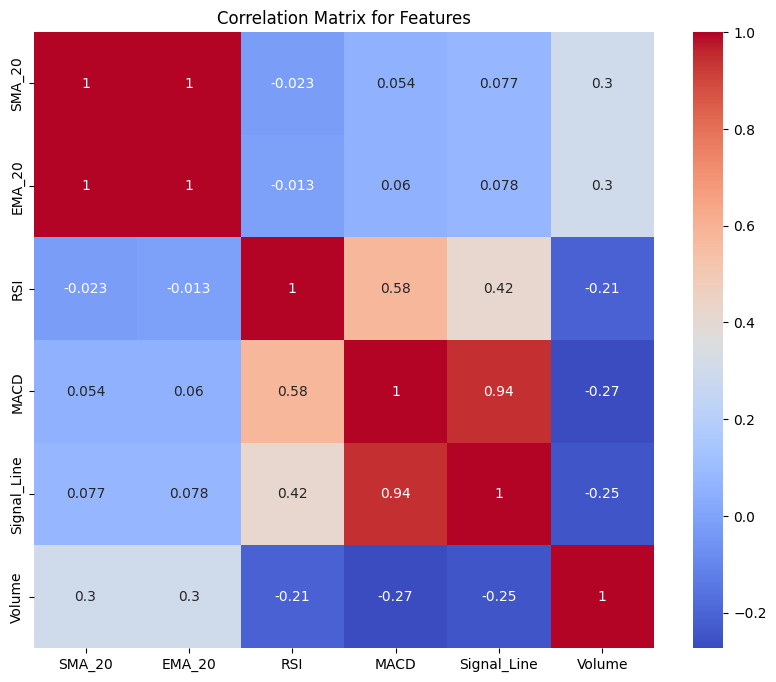

In [7]:
# calculating and plotting correlation matrix; found that ema and sma are perfectly correlated.
# thus, I decided to removee EMA_20 from the training features

correlation_matrix = data[['SMA_20', 'EMA_20', 'RSI', 'MACD', 'Signal_Line', 'Volume']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Features')
plt.show()

# **Random Forest Models**

In [8]:
# selecting training features
X = data[['SMA_20', 'RSI', 'MACD', 'Signal_Line', 'Volume']]
y = data['Log_Returns']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling features to make things standardized
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest with hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf_model = grid_search.best_estimator_

RMSE: 0.013799629530899301


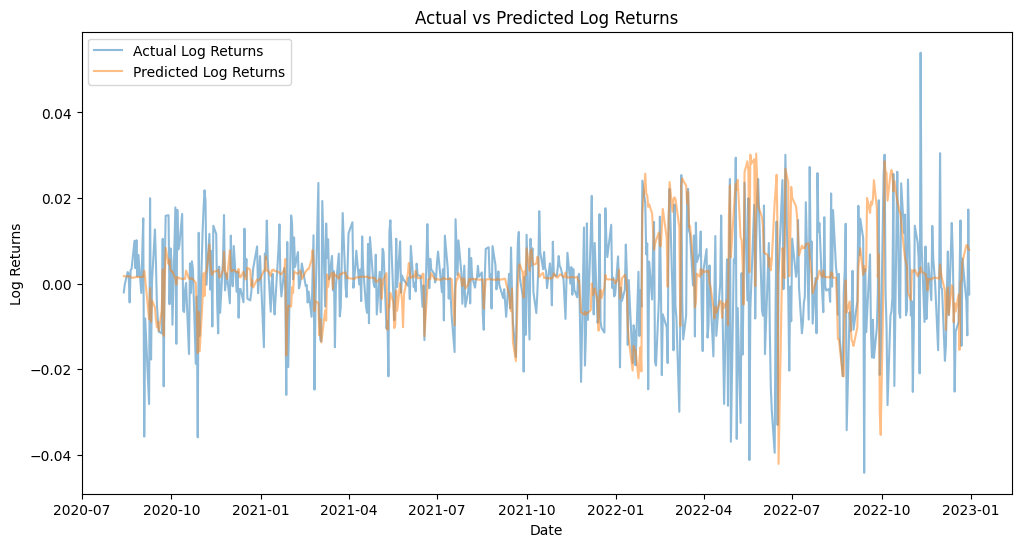

In [9]:
# Making predictions
predictions = best_rf_model.predict(X_test_scaled)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Log Returns', alpha=0.5)
plt.plot(data.index[-len(y_test):], predictions, label='Predicted Log Returns', alpha=0.5)
plt.title('Actual vs Predicted Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

# **LSTM Model**

In [10]:
# scaling features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Log_Returns', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'Signal_Line', 'Volume']])

# function to create a dataset suitable for LSTM/GRU
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100  # Number of time steps to look back
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X.shape[2])))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
73/73 [==============================] - 12s 108ms/step - loss: 0.0128
Epoch 2/100
73/73 [==============================] - 6s 82ms/step - loss: 0.0030
Epoch 3/100
73/73 [==============================] - 8s 107ms/step - loss: 0.0029
Epoch 4/100
73/73 [==============================] - 6s 89ms/step - loss: 0.0029
Epoch 5/100
73/73 [==============================] - 8s 108ms/step - loss: 0.0029
Epoch 6/100
73/73 [==============================] - 6s 83ms/step - loss: 0.0030
Epoch 7/100
73/73 [==============================] - 8s 107ms/step - loss: 0.0028
Epoch 8/100
73/73 [==============================] - 6s 83ms/step - loss: 0.0028
Epoch 9/100
73/73 [==============================] - 8s 108ms/step - loss: 0.0027
Epoch 10/100
73/73 [==============================] - 6s 85ms/step - loss: 0.0028
Epoch 11/100
73/73 [==============================] - 8s 108ms/step - loss: 0.0028
Epoch 12/100
73/73 [==============================] - 6s 83ms/step - loss: 0.0030
Epoch 13/100
73/73

In [12]:
lstm_model.save('sp500_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# testing the model on data from 1/2/2023 to present

new_start_date = '2023-01-02'
new_end_date = '2023-12-31'

new_data = yf.download('^GSPC', start=new_start_date, end=new_end_date)

[*********************100%%**********************]  1 of 1 completed


In [14]:
# creating features similar to training features

new_data['Log_Returns'] = np.log(new_data['Close'] / new_data['Close'].shift(1))

new_data['SMA_20'] = new_data['Close'].rolling(window=20).mean()
new_data['EMA_20'] = new_data['Close'].ewm(span=20, adjust=False).mean()


rsi_series = compute_rsi(new_data['Close'], 14)
rsi_series.index = new_data['Close'].index
new_data['RSI'] = rsi_series


new_data['MACD'], new_data['Signal_Line'] = compute_macd(new_data['Close'])

data.dropna(inplace=True)

In [15]:
new_data_scaled = scaler.transform(new_data[['Log_Returns', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'Signal_Line', 'Volume']])
X_new, _ = create_dataset(new_data_scaled, time_step)
lstm_predictions = lstm_model.predict(X_new)


5/5 [==============================] - 1s 26ms/step


In [16]:
# inversing the scaling for predictions

d = np.zeros((len(lstm_predictions), scaled_data.shape[1]))
d[:, 0] = lstm_predictions.ravel()
lstm_predictions_inverse_scaled = scaler.inverse_transform(d)
lstm_predictions_inverse = lstm_predictions_inverse_scaled[:, 0]


In [17]:
lstm_predictions_inverse

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -2.61415491e-03,
        8.72092643e-04, -6.90689295e-05,  1.22593665e-03, -1.09176424e-03,
       -3.96271315e-03, -2.26624393e-03, -3.17562885e-03, -2.53794535e-03,
       -2.77924325e-03, -8.81478697e-04, -6.67229165e-04, -2.86440417e-03,
       -6.89272027e-03, -6.85970001e-03, -8.86609849e-03, -1.08659810e-02,
       -8.43016372e-03, -5.35212895e-03, -4.44287357e-03, -2.92742636e-03,
       -1.03115154e-03,  7.84535126e-05, -1.56235151e-03, -4.50897886e-03,
       -3.99408823e-03, -2.85685187e-03, -1.63429914e-03, -2.96117212e-04,
        2.32499698e-03,  2.09876481e-03,  4.58575120e-03,  5.28317948e-03,
       -1.21332647e-03, -

In [18]:
actual_log_returns = new_data['Log_Returns'][time_step:].values[:len(lstm_predictions_inverse)]

# removing NaN values from both arrays for a fair comparison
valid_indices = ~np.isnan(actual_log_returns) & ~np.isnan(lstm_predictions_inverse)
clean_actual_log_returns = actual_log_returns[valid_indices]
clean_lstm_predictions_inverse = lstm_predictions_inverse[valid_indices]

In [19]:
mae = mean_absolute_error(clean_actual_log_returns, clean_lstm_predictions_inverse)
mse = mean_squared_error(clean_actual_log_returns, clean_lstm_predictions_inverse)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 0.011294206255522694, MSE: 0.0002160777582757482, RMSE: 0.014699583608924037


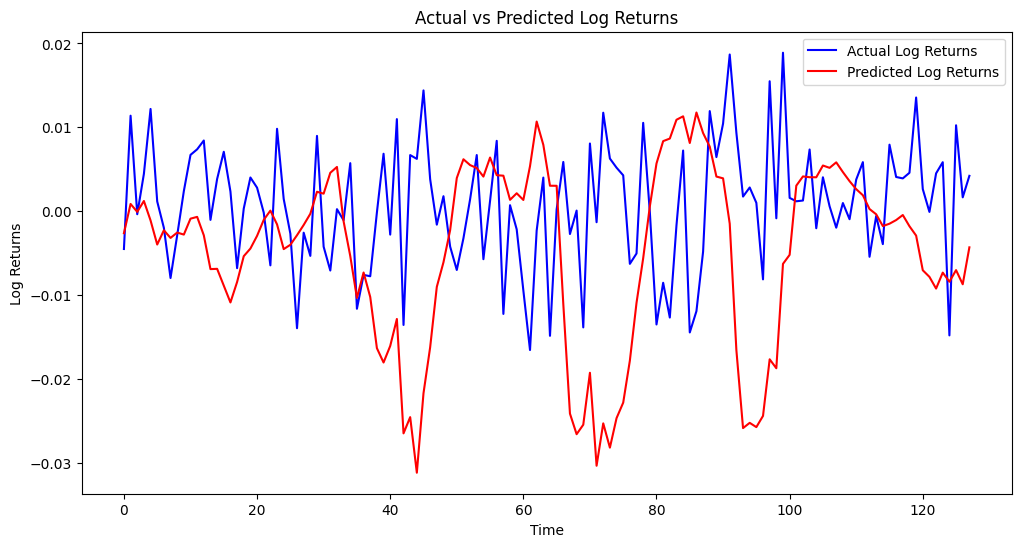

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(clean_actual_log_returns, label='Actual Log Returns', color='blue')
plt.plot(clean_lstm_predictions_inverse, label='Predicted Log Returns', color='red')
plt.title('Actual vs Predicted Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend()
plt.show()


# **GRU Model**

In [21]:
# GRU Model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, X.shape[2])))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dense(units=25))
gru_model.add(Dense(units=1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
73/73 [==============================] - 12s 110ms/step - loss: 0.0208
Epoch 2/100
73/73 [==============================] - 6s 87ms/step - loss: 0.0033
Epoch 3/100
73/73 [==============================] - 8s 109ms/step - loss: 0.0032
Epoch 4/100
73/73 [==============================] - 6s 87ms/step - loss: 0.0030
Epoch 5/100
73/73 [==============================] - 8s 110ms/step - loss: 0.0029
Epoch 6/100
73/73 [==============================] - 6s 87ms/step - loss: 0.0030
Epoch 7/100
73/73 [==============================] - 8s 111ms/step - loss: 0.0029
Epoch 8/100
73/73 [==============================] - 6s 86ms/step - loss: 0.0028
Epoch 9/100
73/73 [==============================] - 8s 111ms/step - loss: 0.0028
Epoch 10/100
73/73 [==============================] - 6s 88ms/step - loss: 0.0028
Epoch 11/100
73/73 [==============================] - 8s 110ms/step - loss: 0.0029
Epoch 12/100
73/73 [==============================] - 6s 88ms/step - loss: 0.0028
Epoch 13/100
73/73

In [22]:
gru_model.save('sp500_gru_model.h5')  # saves to the HDF5 file format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
new_data_scaled = scaler.transform(new_data[['Log_Returns', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'Signal_Line', 'Volume']])
X_new, _ = create_dataset(new_data_scaled, time_step)
gru_predictions = gru_model.predict(X_new)

5/5 [==============================] - 1s 25ms/step


In [24]:
# inversing predictions
dummy_array = np.zeros((len(gru_predictions), scaled_data.shape[1]))
dummy_array[:, 0] = gru_predictions.ravel()
gru_predictions_inverse_scaled = scaler.inverse_transform(dummy_array)
gru_predictions_inverse = gru_predictions_inverse_scaled[:, 0]

In [25]:
gru_predictions_inverse

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.00359981,
       -0.00548767, -0.00566181, -0.00518369, -0.00444891, -0.00448218,
       -0.00517783, -0.00350976, -0.00314925, -0.00362013, -0.00428101,
       -0.00434494, -0.00407194, -0.00402616, -0.00387779, -0.00367795,
       -0.00343221, -0.00374568, -0.00383842, -0.00413592, -0.00449416,
       -0.00483585, -0.00481839, -0.0039204 , -0.00476556, -0.00475901,
       -0.00496006, -0.00461138, -0.00525348, -0.00548469, -0.00585429,
       -0.00492609, -0.00356774, -0.00353432, -0.00364632, -0.00415082,
       -0.00258396, -0.00198269, -0.00318446, -0.00378402, -0.00308925,
       -0.00082453, -0.00152059, -0.00014414, -0.00328424, -0.00360439,
       -0.00323988, -0.00222466, -0.00177913, -0.00235992, -0.00

In [26]:
actual_log_returns = new_data['Log_Returns'][time_step:].values[:len(gru_predictions_inverse)]

# Remove NaN values from both arrays for a fair comparison
valid_indices = ~np.isnan(actual_log_returns) & ~np.isnan(gru_predictions_inverse)
clean_actual_log_returns = actual_log_returns[valid_indices]
clean_gru_predictions_inverse = gru_predictions_inverse[valid_indices]

In [27]:
mae = mean_absolute_error(clean_actual_log_returns, clean_gru_predictions_inverse)
mse = mean_squared_error(clean_actual_log_returns, clean_gru_predictions_inverse)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 0.007054772864505647, MSE: 7.30077455767395e-05, RMSE: 0.008544457008888248


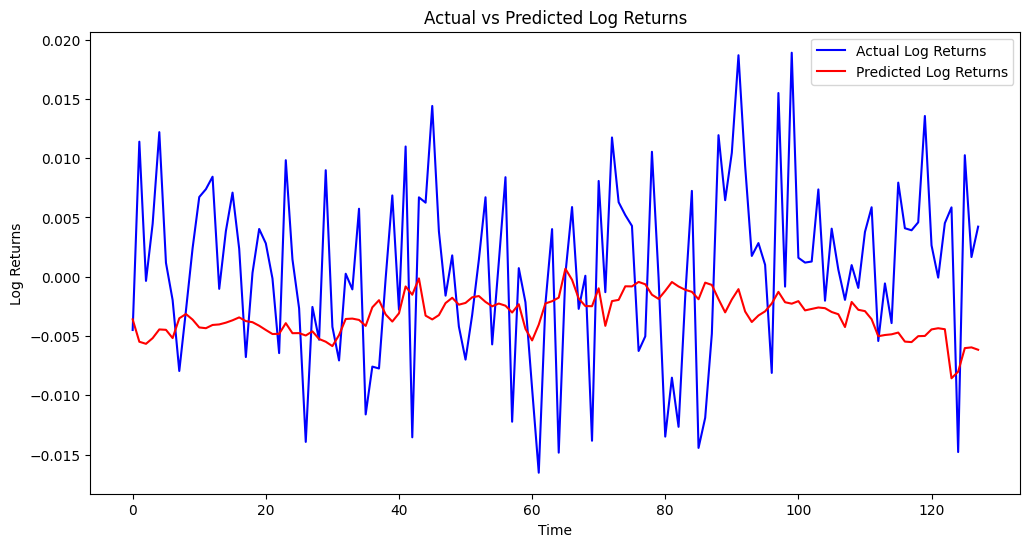

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(clean_actual_log_returns, label='Actual Log Returns', color='blue')
plt.plot(clean_gru_predictions_inverse, label='Predicted Log Returns', color='red')
plt.title('Actual vs Predicted Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend()
plt.show()
